# Autenticación Biométrica - SIFT
En esta hipótesis hemos propuesto hacer uso del detector de características SIFT para tratar de autenticar a usuarios en una base de datos a través de sus huellas dactilares, obteniendo patrones y características clave de las huellas para posteriormente corroborarlas con nuestra base de datos y verificar si pertencen o no a nuestro sistema.

### Importación de librerías utilizadas

In [6]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

### Preprocesamiento de las imágenes de las huellas
El preprocesamiento de las imágenes de las huellas incluye dos pasos principales: recorte y filtrado.
1. Recorte: Se localiza el contorno más grande en cada imagen, que corresponde a la huella, y se recorta para eliminar bordes innecesarios y centrarse en las áreas importantes. Esto permite trabajar con imágenes uniformes y enfocadas.

2. Filtrado: Para mejorar la calidad de las huellas y resaltar sus detalles clave, se aplicaron varias técnicas:
    - Ecualización con CLAHE para mejorar el contraste en áreas oscuras.
    - Filtro bilateral para suavizar sin perder bordes importantes.
    - Filtro de mediana para eliminar ruido sin degradar líneas finas.
    - Binarización adaptativa para segmentar crestas y valles bajo distintas condiciones de iluminación.
    - Limpieza morfológica para eliminar ruido.
    - Esqueletonizado para reducir la huella a su estructura básica y facilitar el análisis.

Imagen recortada guardada en imagenes_recortadas\11f_01.png
Imagen recortada guardada en imagenes_recortadas\11s_01.png
Imagen recortada guardada en imagenes_recortadas\12f_01.png
Imagen recortada guardada en imagenes_recortadas\12s_01.png
Imagen recortada guardada en imagenes_recortadas\13f_01.png
Imagen recortada guardada en imagenes_recortadas\13s_01.png
Imagen recortada guardada en imagenes_recortadas\14f_01.png
Imagen recortada guardada en imagenes_recortadas\14s_01.png
Imagen recortada guardada en imagenes_recortadas\15f_01.png
Imagen recortada guardada en imagenes_recortadas\15s_01.png
Imagen recortada guardada en imagenes_recortadas\16f_01.png
Imagen recortada guardada en imagenes_recortadas\16s_01.png
Imagen recortada guardada en imagenes_recortadas\17f_01.png
Imagen recortada guardada en imagenes_recortadas\17s_01.png
Imagen recortada guardada en imagenes_recortadas\18f_01.png
Imagen recortada guardada en imagenes_recortadas\18s_01.png
Imagen recortada guardada en imagenes_re

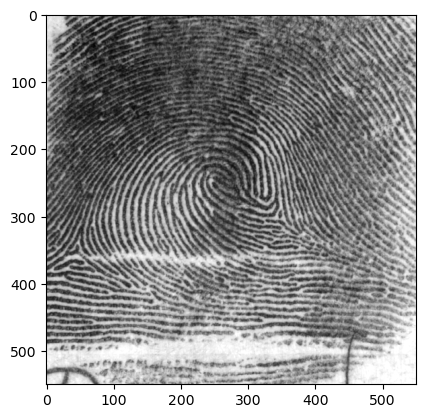

In [8]:
def recortar_imagen(input_folder, output_folder, crop_width=550, crop_height=550, threshold_value=225):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if not file.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar tipos de imagen
                continue

            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Error al leer la imagen {img_path}")
                continue

            # Binarización de la imagen
            _, thresh = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)

            # Encontrar contornos
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Seleccionar el contorno más grande
                largest_contour = max(contours, key=cv2.contourArea)

                # Calcular el rectángulo para el contorno
                x, y, w, h = cv2.boundingRect(largest_contour)

                # Calcular el centro del contorno
                center_x, center_y = x + w // 2, y + h // 2

                # Determinar las coordenadas del recorte
                x_start = max(center_x - crop_width // 2, 0)
                y_start = max(center_y - crop_height // 2, 0)
                x_end = min(center_x + crop_width // 2, img.shape[1])
                y_end = min(center_y + crop_height // 2, img.shape[0])

                # Ajustar el tamaño del recorte si es necesario
                if (x_end - x_start) != crop_width:
                    x_start = max(0, x_end - crop_width)
                if (y_end - y_start) != crop_height:
                    y_start = max(0, y_end - crop_height)

                # Realizar el recorte
                cropped_img = img[y_start:y_end, x_start:x_end]

                output_path = os.path.join(output_folder, file)
                cv2.imwrite(output_path, cropped_img)
                print(f"Imagen recortada guardada en {output_path}")

input_folder = 'imagenes_huellas'   # Directorio de imágenes de entrada
output_folder = 'imagenes_recortadas'  # Directorio donde se guardarán las imágenes recortadas

recortar_imagen(input_folder, output_folder)

# Imagen de ejemplo
img = cv2.imread('imagenes_recortadas/11f_01.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()

In [2]:
def procesar_imagen(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: No se pudo cargar la imagen {image_path}.")
        return
    
    # Ecualización de histograma local con CLAHE para mejorar el contraste
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(image)
    
    # Filtrado bilateral para suavizar la imagen y quedarnos con los bordes
    bilateral_filtered = cv2.bilateralFilter(equalized_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Filtrado de mediana para eliminar ruido
    median_filtered = cv2.medianBlur(bilateral_filtered, 3)
    
    # Binarización adaptativa para quedarnos con las crestas y valles de la huella
    thresh_image = cv2.adaptiveThreshold(
        median_filtered,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        19,
        3
    )
    
    # Invertir la imagen binaria (blanco a negro y viceversa)
    inverted_image = cv2.bitwise_not(thresh_image)
    
    # Operación apertura para eliminar ruido residual
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    
    # Esqueletonización para reducir la huella a líneas de un píxel
    skeleton = np.zeros(cleaned_image.shape, np.uint8)
    img = cleaned_image.copy()
    while True:
        eroded = cv2.erode(img, None)  
        temp = cv2.dilate(eroded, None)  
        temp = cv2.subtract(img, temp) 
        skeleton = cv2.bitwise_or(skeleton, temp)  
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:  
            break

    # Guardar la imagen procesada
    cv2.imwrite(output_path, skeleton)
    print(f"Imagen procesada y guardada en {output_path}")



input_dir = 'imagenes_recortadas'  
output_dir = 'imagenes_filtradas' 

os.makedirs(output_dir, exist_ok=True)

# Procesar todas las imágenes PNG en el directorio de entrada
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.png'):  
            image_path = os.path.join(root, file)
            output_path = os.path.join(output_dir, file)
            
            procesar_imagen(image_path, output_path)


Imagen procesada y guardada en imagenes_filtradas\11f_01.png
Imagen procesada y guardada en imagenes_filtradas\11s_01.png
Imagen procesada y guardada en imagenes_filtradas\12f_01.png
Imagen procesada y guardada en imagenes_filtradas\12s_01.png
Imagen procesada y guardada en imagenes_filtradas\13f_01.png
Imagen procesada y guardada en imagenes_filtradas\13s_01.png
Imagen procesada y guardada en imagenes_filtradas\14f_01.png
Imagen procesada y guardada en imagenes_filtradas\14s_01.png
Imagen procesada y guardada en imagenes_filtradas\15f_01.png
Imagen procesada y guardada en imagenes_filtradas\15s_01.png
Imagen procesada y guardada en imagenes_filtradas\16f_01.png
Imagen procesada y guardada en imagenes_filtradas\16s_01.png
Imagen procesada y guardada en imagenes_filtradas\17f_01.png
Imagen procesada y guardada en imagenes_filtradas\17s_01.png
Imagen procesada y guardada en imagenes_filtradas\18f_01.png
Imagen procesada y guardada en imagenes_filtradas\18s_01.png
Imagen procesada y guard

In [3]:
from hmac import new
import os
import cv2
import random
import numpy as np

def new_images(input_dir, num_images):
    images = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    
    for image_name in images:
        image_path = os.path.join(input_dir, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
        
        for i in range(num_images):
            img_copy = img.copy()
            
            # Rotación aleatoria
            angle = random.randint(-360, 360)
            h, w = img_copy.shape
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            augmented_img = cv2.warpAffine(img_copy, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Escalado aleatorio
            scale_x = random.uniform(0.5, 1.2)
            scale_y = random.uniform(0.5, 1.2)
            augmented_img = cv2.resize(augmented_img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            
            #if input_dir.endswith('rejected'):
            # Corte parcial (simulando mal contacto)
            x1, y1 = random.randint(0, w // 8), random.randint(0, h // 8)
            x2, y2 = random.randint(x1, w // 4), random.randint(y1, h // 4)
            cv2.rectangle(augmented_img, (x1, y1), (x2, y2), (0, 0, 0), -1)
            
            # Traslación aleatoria
            max_shift = 10  # Máximo desplazamiento en píxeles
            tx = random.randint(-max_shift, max_shift)
            ty = random.randint(-max_shift, max_shift)
            translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
            augmented_img = cv2.warpAffine(augmented_img, translation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Guardar imagen aumentada en el mismo directorio
            output_name = f"{i}_{image_name}"
            cv2.imwrite(os.path.join(input_dir, output_name), augmented_img)
            

input_dir = 'user_prueba'
new_images(input_dir, 1)


In [4]:
import os
import shutil

# Directorio de entrada
input_dir = 'imagenes_filtradas'

# Directorios de salida
output_dir = 'user_database'
os.makedirs(output_dir, exist_ok=True)

# Organizar las imágenes en carpetas por usuario
for image_name in os.listdir(input_dir):
    if image_name.endswith('.png'):
        user_id = image_name[:2]  # Extraer el identificador del usuario (ejemplo: "11", "12")
        user_dir = os.path.join(output_dir, f"user{user_id}")
        os.makedirs(user_dir, exist_ok=True)
        shutil.copy(os.path.join(input_dir, image_name), os.path.join(user_dir, image_name))

print("Base de datos creada con éxito.")


Base de datos creada con éxito.


In [5]:
def extract_features(image_path):
    """Extrae puntos clave y descriptores usando SIFT."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(image, None)
    return descriptors

def match_fingerprints(des1, des2, ratio_threshold=0.75):
    """Compara dos conjuntos de descriptores SIFT y devuelve las coincidencias."""
    if des1 is None or des2 is None:
        return 0
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]
    return len(good_matches)


In [6]:
def evaluate_database(database_dir, test_dir, match_threshold=20):
    """Evalúa las huellas y devuelve las etiquetas reales y los puntajes."""
    true_labels = []
    scores = []

    for test_image in os.listdir(test_dir):
        test_path = os.path.join(test_dir, test_image)
        test_des = extract_features(test_path)

        max_matches = 0
        for user_folder in os.listdir(database_dir):
            user_path = os.path.join(database_dir, user_folder)
            for db_image in os.listdir(user_path):
                db_path = os.path.join(user_path, db_image)
                db_des = extract_features(db_path)

                matches = match_fingerprints(test_des, db_des)
                max_matches = max(max_matches, matches)

        # Etiquetar como autenticada si contiene "s" o "f", de lo contrario es rechazada
        true_labels.append(1 if "s" in test_image or "f" in test_image else 0)
        scores.append(max_matches)

    return true_labels, scores


In [7]:
def visualize_matches(image1_path, image2_path, ratio_threshold=0.75):
    """Muestra las coincidencias entre dos imágenes de huellas."""
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(match_img, cmap='gray')
    plt.title(f"Coincidencias: {len(good_matches)}")
    plt.show()


In [8]:
def authenticate_user(new_fingerprint_path, database_dir, match_threshold=100):
    """Compara una nueva huella con la base de datos organizada por usuario."""
    new_descriptors = extract_features(new_fingerprint_path)
    if new_descriptors is None:
        return "No se encontraron características en la huella nueva."
    
    max_matches = 0
    best_user = None

    for user_dir in os.listdir(database_dir):
        user_path = os.path.join(database_dir, user_dir)
        for fingerprint_path in os.listdir(user_path):
            full_path = os.path.join(user_path, fingerprint_path)
            db_descriptors = extract_features(full_path)

            if db_descriptors is None:
                continue
            
            match_count = match_fingerprints(new_descriptors, db_descriptors)
            print(f"Comparando con {full_path}, Coincidencias: {match_count}")

            if match_count > max_matches:
                max_matches = match_count
                best_user = user_dir

    if max_matches >= match_threshold:
        return f"Huella autenticada como del usuario {best_user} con {max_matches} coincidencias."
    else:
        return f"Huella rechazada. Máximas coincidencias: {max_matches}"


In [8]:
def calculate_det(true_labels, scores):
    thresholds = sorted(set(scores))
    fpr_list = []
    fnr_list = []

    for threshold in thresholds:
        tp = fp = tn = fn = 0
        for label, score in zip(true_labels, scores):
            if score >= threshold:
                if label == 1: tp += 1
                else: fp += 1
            else:
                if label == 1: fn += 1
                else: tn += 1
        
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        fpr_list.append(fpr)
        fnr_list.append(fnr)
    
    return fpr_list, fnr_list

def plot_det(fpr, fnr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, fnr, linestyle='-', label="DET Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("False Negative Rate (FNR)")
    plt.title("DET Curve")
    plt.grid()
    plt.legend()
    plt.show()

    # Calcular ERR
    eer_index = np.nanargmin(np.abs(np.array(fpr) - np.array(fnr)))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    print(f"Equal Error Rate (ERR): {eer:.4f}")


In [15]:
# Ejecutar evaluación
database_dir = 'user_database'
test_dir = 'user_prueba'

# Evaluar las huellas
true_labels, scores = evaluate_database(database_dir, test_dir)

# Graficar la DET
fpr, fnr = calculate_det(true_labels, scores)
plot_det(fpr, fnr)

NameError: name 'calculate_det' is not defined

In [14]:
# Autenticar una huella específica
new_fingerprint = 'user_prueba/.png'
result = authenticate_user(new_fingerprint, database_dir)
print(result)

Comparando con user_database\user11\11f_01.png, Coincidencias: 34
Comparando con user_database\user11\11s_01.png, Coincidencias: 45
Comparando con user_database\user12\12f_01.png, Coincidencias: 49
Comparando con user_database\user12\12s_01.png, Coincidencias: 46
Comparando con user_database\user13\13f_01.png, Coincidencias: 49
Comparando con user_database\user13\13s_01.png, Coincidencias: 54
Comparando con user_database\user14\14f_01.png, Coincidencias: 52
Comparando con user_database\user14\14s_01.png, Coincidencias: 42
Comparando con user_database\user15\15f_01.png, Coincidencias: 55
Comparando con user_database\user15\15s_01.png, Coincidencias: 41
Comparando con user_database\user16\16f_01.png, Coincidencias: 52
Comparando con user_database\user16\16s_01.png, Coincidencias: 44
Comparando con user_database\user17\17f_01.png, Coincidencias: 52
Comparando con user_database\user17\17s_01.png, Coincidencias: 53
Comparando con user_database\user18\18f_01.png, Coincidencias: 49
Comparando